<a href="https://colab.research.google.com/github/Shamil2007/DataAnalysis/blob/main/Data-Cleaning/handling_missing_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's start with creating a dataset manually

#Creation of Dataset

In [1]:
import numpy as np
import pandas as pd

In [2]:
np.random.seed(42)

# -------------------------------
# Create "complete" dataset
# -------------------------------


n = 5000  # number of rows

# Numerical - Continuous
age = np.random.randint(18, 70, size=n)            # age in years
income = np.random.lognormal(mean=np.log(50000), sigma=0.5, size=n)     # annual income

# Numerical - Discrete
num_children = np.random.poisson(1.5, size=n)         # number of children

# Categorical - Binary
gender = np.random.choice(['Male', 'Female'], size=n)

# Categorical - Multi-class
education = np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], size=n)

# Optional Time-Series (daily visits)
dates = pd.date_range('2025-01-01', periods=n)
visits = np.random.poisson(2.5, size=n)

# Build DataFrame
df_complete = pd.DataFrame({
    'age': age,
    'income': income,
    'num_children': num_children,
    'gender': gender,
    'education': education,
    'visits': visits,
    'date': dates
})

# Keep a copy of complete dataset (ground truth)
df_ground_truth = df_complete.copy()

In [3]:
# ---------------------------------------------
# Inject missing values
# ---------------------------------------------


df = df_complete.copy()

mcar_idx = np.random.choice(df.index, size=int(0.18 * n), replace=False)
df.loc[mcar_idx, 'age'] = np.nan

mar_idx = df[df['age'] > 50].sample(frac=0.35, random_state=42).index
df.loc[mar_idx, 'income'] = np.nan

income_threshold = np.percentile(df['income'], 85)
mnar_idx = df[df['income'] >= income_threshold].sample(frac=0.5, random_state=42).index
df.loc[mnar_idx, 'income'] = np.nan

mcar_children = np.random.choice(df.index, size=int(0.05 * n), replace=False)
df.loc[mcar_children, 'num_children'] = np.nan

gender_missing_idx = np.random.choice(df.index, size=int(0.1 * n), replace=False)
df.loc[gender_missing_idx, 'gender'] = np.nan

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   age           4100 non-null   float64       
 1   income        4477 non-null   float64       
 2   num_children  4750 non-null   float64       
 3   gender        4500 non-null   object        
 4   education     5000 non-null   object        
 5   visits        5000 non-null   int64         
 6   date          5000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 273.6+ KB


Looking at the dataset, we can see that most of the missing information comes from the Age column. After that, the Income field has the next largest gap, followed by Number of Children and finally Gender.

In [5]:
df.describe()

,age,income,num_children,visits,date
count,4100.000000,4477.000000,4750.000000,5000.00000,5000
mean,43.391463,56226.206666,1.538105,2.48380,2031-11-05 12:00:00
min,18.000000,8339.403589,0.000000,0.00000,2025-01-01 00:00:00
25%,30.750000,35304.587910,1.000000,1.00000,2028-06-03 18:00:00
50%,43.000000,49321.349418,1.000000,2.00000,2031-11-05 12:00:00
75%,56.000000,69625.067825,2.000000,3.00000,2035-04-08 06:00:00
max,69.000000,257294.843424,8.000000,10.00000,2038-09-09 00:00:00
std,14.906529,30096.530308,1.248845,1.56225,NaN


#Step 0: Diagnose Missingness Patterns

Before filling or deleting missing values, you should understand why values are missing:

1. MCAR (Missing Completely at Random): Missingness is independent of both observed and unobserved data.

    - Example: Random survey questions skipped.

2. MAR (Missing at Random): Missingness depends on observed data, not on the missing values themselves.

    - Example: Older patients may not report weight, but age is known.

3. MNAR (Missing Not at Random): Missingness depends on the missing values themselves.

    - Example: People with high income tend to hide it.

## MCAR (Missing Completely at Random)

### What does MCAR mean?
MCAR happens when data goes missing **completely by chance**.  
The missing values do not depend on:
- the values we see (observed data), or  
- the values we don’t see (unobserved data).  

👉 In other words, the missing values are **just random noise**.

---

### Why is this important?
- **No bias**: The analysis results are still correct.  
  *(Bias = systematic error that makes results wrong.)*  
- **Lower efficiency**: We lose information because the sample size is smaller.  
  *(Efficiency = how precise our estimates are. Fewer data → less precision.)*

---

### Mathematical Form
P(Y is missing | Y, X) = P(Y is missing)  
This means: the probability that Y is missing does not depend on any data (X or Y).  

---

### Simple Examples
- A sensor randomly stops recording sometimes, with no reason.  
- People taking a survey skip some questions purely by accident.  

---

### How to Test if Data is MCAR
1. **Little’s MCAR Test**  
   - A formal statistical test.  
   - If result is *not significant* → consistent with MCAR.  
   - If *significant* → data probably not MCAR.  

2. **Mean Comparison (t-test or similar)**  
   - Compare averages between "missing" and "non-missing" groups.  
   - Big differences → missingness is not random.  
   - No differences → missingness *might* be random.  

⚠️ Important: Failing to find differences does **not prove** MCAR. It only means we didn’t find evidence against it.  

---

### How to Handle MCAR
Since MCAR introduces **no bias**, we can use simple methods:

- **Complete Case Analysis (Listwise Deletion):**  
  Remove rows with missing values. This is safe under MCAR, but reduces dataset size.  

- **USVT (Universal Singular Value Thresholding):**  
  A method that tries to recover patterns, but only restores the **average trend**, not the full detail.  

- **SoftImpute:**  
  Fills missing values using matrix completion. Works fine for MCAR, weaker if data is not MCAR.  

- **Synthetic Nearest Neighbor Imputation:**  
  Looks for "similar" rows to fill in missing values. Works well for MCAR, sometimes also for more difficult cases.  

---

### Extra Notes
- Missingness in one column can still be related to missingness in another, and it’s still MCAR.  
- Just because we can’t find evidence of bias doesn’t **prove** MCAR—it only means we don’t see problems.  


## MAR (Missing at Random)

### What does MAR mean?
MAR happens when missing data depends on **other observed information**, but **not on the missing values themselves**.  

- In simple words: if we know some other data, we can explain why some values are missing.  
- There is a **systematic pattern** in missingness, but it’s based only on data we can see.  

---

### Mathematical Form
P(Y is missing | Y, X) = P(Y is missing | X)  

- This means: the probability that Y is missing depends only on observed data (X), not on Y itself.  

---

### Key Characteristics
- Missingness is related to observed variables.  
- Missingness is **not related to the missing value itself**.  
- Analyses **must account for observed data** to reduce bias.  

*(Bias = error in results caused by missing or unaccounted factors)*  

---

### Simple Examples
- Women might be less likely to report their weight, but gender is recorded → weight is MAR.  
- Income data missing is related to education level (observed).  
  - E.g., people with higher education may be less willing to disclose income.  

---

### Challenges of MAR
- MAR is **harder to deal with** than MCAR.  
- We **cannot directly test** for MAR.  
- Evidence relies on:
  - **Domain knowledge** (understanding the subject)  
  - Indirect statistical checks  

---

### How to Handle MAR
Methods assume that the observed variables explain the missingness:

1. **Multiple Imputation by Chained Equations (MICE)**  
   - Fills missing values iteratively using other observed data.  

2. **Maximum Likelihood Estimation**  
   - Estimates model parameters while considering MAR assumptions.  

3. **Regression-Based Imputation**  
   - Predicts missing values using other variables.  

✅ Effective handling requires **careful modeling** and sometimes **domain-specific knowledge**.  

---

### Notes
- Always check which variables could explain missingness.  
- Unlike MCAR, ignoring missing data under MAR **can introduce bias**.  


## MNAR (Missing Not at Random)

### What does MNAR mean?
MNAR happens when missing data **depends on the missing value itself** or some **unobserved factors**.  

- In simple words: we **cannot explain the missingness** just by looking at the data we have.  
- Ignoring MNAR can lead to **serious bias** in results.  

*(Bias = systematic error that makes results inaccurate.)*  

---

### Mathematical Form
P(Y is missing | Y, X) ≠ P(Y is missing | X)  

- This means: the probability of missing depends on the **missing values themselves**, not just observed data.  

---

### Key Characteristics
- Missingness **cannot be fully explained** by observed data.  
- Causes of missingness are directly linked to **unobserved or missing values**.  
- Ignoring MNAR → **wrong conclusions** in analysis.  

---

### Simple Examples
- Wealthy people are less likely to report their income → income missing depends on income itself.  
- Patients with severe symptoms drop out of a study → missing data depends on health status.  

---

### Challenges of MNAR
- MNAR is the **hardest type** of missingness to handle.  
- Requires **explicit modeling** of missingness mechanism.  
- Often needs **domain knowledge** or **extra data**.  

---

### How to Handle MNAR
Methods that explicitly model missingness:

1. **Heckman Selection Models**  
   - Adjusts for missing data caused by selection process.  

2. **Instrumental Variables**  
   - Uses variables related to missingness but unrelated to outcome to reduce bias.  

3. **Pattern-Mixture Models**  
   - Divide data into groups based on missingness patterns and model each separately.  

4. **Sensitivity Analysis**  
   - Checks how results change under different assumptions about missingness.  

---

### Using Auxiliary Data
Auxiliary data = extra information that helps explain missingness:

- **Surrogate Variables:** Variables that correlate with missing data to improve imputation.  
- **External Datasets:** Merge with other datasets to provide predictors for missingness.  
- **Applications in Business:** Customer demographics or transaction history to predict missing survey responses.  

---

### Extra Strategies
- Follow-up surveys or targeted sampling can **reduce MNAR problems**, but may require **extra resources and planning**.  

✅ Key point: Handling MNAR is **complex** and requires **careful modeling** and sometimes external information.


#Step 1: Diagnosing The Missing Data

##Verify missingness

In [6]:
missingData_perc = df.isna().mean() * 100

print("Percentage of missing data %: ")
print(missingData_perc)

Percentage of missing data %: 
age             18.00
income          10.46
num_children     5.00
gender          10.00
education        0.00
visits           0.00
date             0.00
dtype: float64


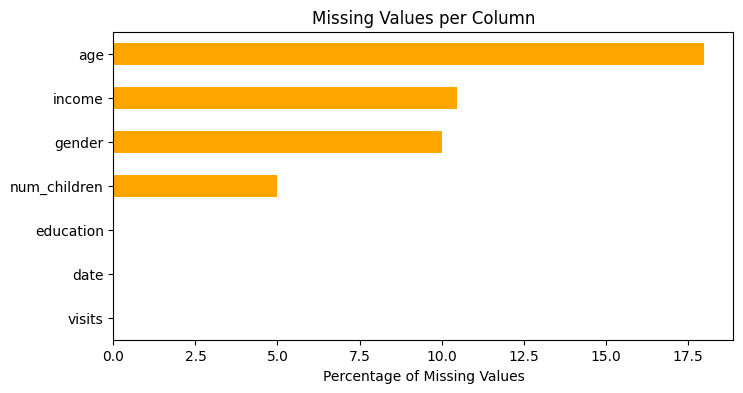

In [7]:
import matplotlib.pyplot as plt


missingData_perc.sort_values().plot(kind='barh', figsize=(8,4), color='orange')
plt.xlabel('Percentage of Missing Values')
plt.title('Missing Values per Column')
plt.show()

In [8]:
missingColumns = [col_name for col_name, value in df.isna().sum().items() if value > 0]

In [9]:
missingDataSet = df[missingColumns].copy()
missingDataSet

,age,income,num_children,gender
0,56.0,47329.711742,2.0,Male
1,69.0,64120.596725,0.0,Female
2,46.0,41236.811550,1.0,Female
3,32.0,61697.859858,1.0,Male
4,60.0,32454.122282,2.0,Female
...,...,...,...,...
4995,24.0,32180.660749,1.0,Female
4996,66.0,257294.843424,1.0,Female
4997,26.0,65499.014971,3.0,Female
4998,53.0,NaN,2.0,NaN


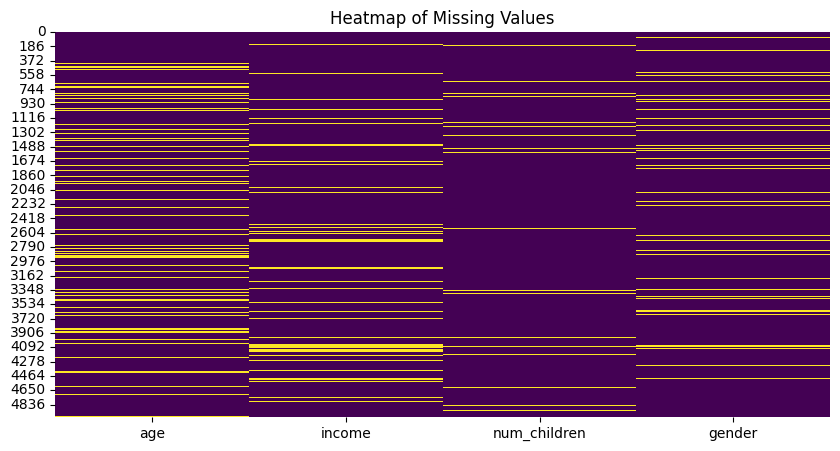

In [10]:
import seaborn as sns

plt.figure(figsize=(10,5))
sns.heatmap(missingDataSet.isna(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

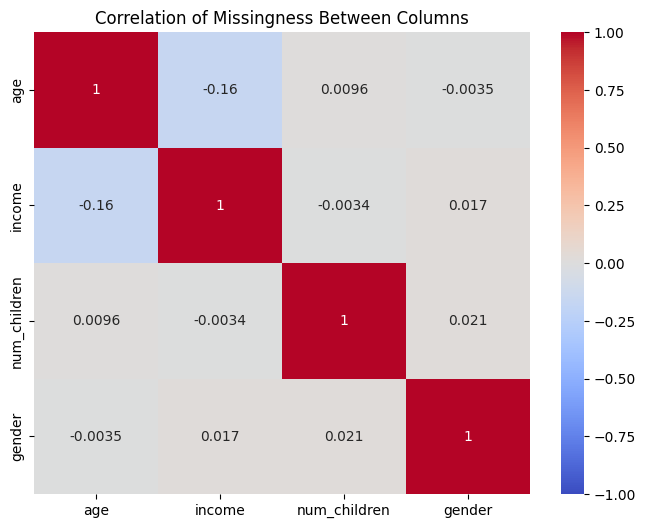

In [11]:
missing_bool = missingDataSet.isna().astype(int)
plt.figure(figsize=(8,6))
sns.heatmap(missing_bool.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Missingness Between Columns')
plt.show()

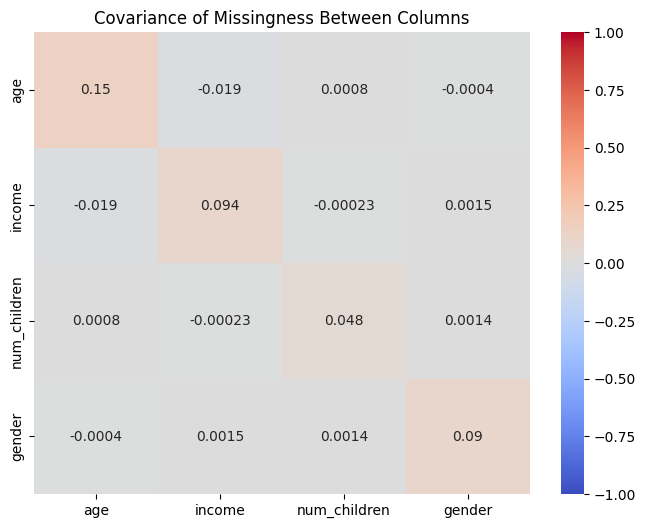

In [12]:
missing_bool = missingDataSet.isna().astype(int)
plt.figure(figsize=(8,6))
sns.heatmap(missing_bool.cov(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Covariance of Missingness Between Columns')
plt.show()

#Step 2: Deletion (Removing Missing Data)

##A. Listwise Deletion (Drop rows with any missing values)

Explanation: Remove rows where any column has missing data.

When to use:

    MCAR or very small missing percentage (<5%).

    Pros: Simple, no assumptions.

    Cons: Loss of data; can bias results if not MCAR.

In [13]:
df_clean = df.dropna().copy()
df_clean

,age,income,num_children,gender,education,visits,date
0,56.0,47329.711742,2.0,Male,PhD,2,2025-01-01
1,69.0,64120.596725,0.0,Female,Master,3,2025-01-02
2,46.0,41236.811550,1.0,Female,Bachelor,4,2025-01-03
3,32.0,61697.859858,1.0,Male,PhD,2,2025-01-04
4,60.0,32454.122282,2.0,Female,High School,0,2025-01-05
...,...,...,...,...,...,...,...
4994,21.0,36679.015012,0.0,Female,High School,3,2038-09-04
4995,24.0,32180.660749,1.0,Female,PhD,2,2038-09-05
4996,66.0,257294.843424,1.0,Female,High School,5,2038-09-06
4997,26.0,65499.014971,3.0,Female,PhD,2,2038-09-07


In [14]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3075 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   age           3075 non-null   float64       
 1   income        3075 non-null   float64       
 2   num_children  3075 non-null   float64       
 3   gender        3075 non-null   object        
 4   education     3075 non-null   object        
 5   visits        3075 non-null   int64         
 6   date          3075 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 192.2+ KB


`df.dropna()` removes all rows (or columns) that contain **NaN (missing) values**.  

When to use it
- Works well when the **amount of missing data is small**.  
- Can be used for **MNAR (Missing Not at Random)**, but be careful:
  - Removing too many rows can **reduce sample size**.  
  - May introduce **bias** if missing data is not random.  

Notes
- By default, `df.dropna()` removes rows.  
- You can also remove columns using `df.dropna(axis=1)`.  
- Always check how much data you are removing to avoid losing important information.  


In [15]:
df_clean = df.dropna(subset=["num_children"]).copy()
df_clean

,age,income,num_children,gender,education,visits,date
0,56.0,47329.711742,2.0,Male,PhD,2,2025-01-01
1,69.0,64120.596725,0.0,Female,Master,3,2025-01-02
2,46.0,41236.811550,1.0,Female,Bachelor,4,2025-01-03
3,32.0,61697.859858,1.0,Male,PhD,2,2025-01-04
4,60.0,32454.122282,2.0,Female,High School,0,2025-01-05
...,...,...,...,...,...,...,...
4995,24.0,32180.660749,1.0,Female,PhD,2,2038-09-05
4996,66.0,257294.843424,1.0,Female,High School,5,2038-09-06
4997,26.0,65499.014971,3.0,Female,PhD,2,2038-09-07
4998,53.0,NaN,2.0,NaN,High School,2,2038-09-08


You can remove rows with missing values **only in a specific column** using `subset`:

    df.dropna(subset=["num_children"])

##B. Pairwise Deletion (Drop data per analysis)

Explanation: Only exclude missing values in the specific analysis.

- Useful for correlation or regression: include rows where required columns are not missing.

In [16]:
df[['age', 'income']].corr()

,age,income
age,1.000000,0.007419
income,0.007419,1.000000


In [17]:
df[['age', 'income']].cov()

,age,income
age,222.204611,3.226748e+03
income,3226.747927,9.058011e+08


#Step 3: Simple Imputation

## A. Mean Imputation

- Explanation: Replace missing values with the column mean.

When to use:

- Continuous numeric columns, MCAR, low missingness (<5%).

- Pros: Simple, preserves dataset size.

- Cons: Reduces variance, can bias distribution.

In [18]:
age_mean = round(df['age'].mean(), 2)
df['age'] = df['age'].fillna(age_mean)
df['age']

,age
0,56.0
1,69.0
2,46.0
3,32.0
4,60.0
...,...
4995,24.0
4996,66.0
4997,26.0
4998,53.0


Be careful:

    1. Do not use with highly skewed data.

    2. Can distort relationships between variables.

## B. Median Imputation

- Explanation: Replace missing with median (better for skewed data).

In [19]:
income_median = round(df['income'].median(), 2)
df['income'] = df['income'].fillna(income_median)
df['income']

,income
0,47329.711742
1,64120.596725
2,41236.811550
3,61697.859858
4,32454.122282
...,...
4995,32180.660749
4996,257294.843424
4997,65499.014971
4998,49321.350000


Be carefull:

    - Doesn’t capture variability; still can distort correlations.

##C. Mode Imputation (Categorical)

- Explanation: Fill missing categorical values with most frequent value.

In [20]:
gender_mode = df['gender'].mode()[0]
df['gender'] = df['gender'].fillna(gender_mode)
df['gender']

,gender
0,Male
1,Female
2,Female
3,Male
4,Female
...,...
4995,Female
4996,Female
4997,Female
4998,Male


Be careful:

    1. Over-representation of the mode.

    2. Can distort downstream analysis if missing not random.

#ML-Based Imputation
## A. K-Nearest Neighbors (KNN) Imputation

- Explanation: Predict missing values using similar rows.

In [21]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)

# Reshape to 2D (n_samples, n_features)
num_children_imputed = imputer.fit_transform(df[['num_children']])
print(f"Shape: {num_children_imputed.shape}")

# Assign back to DataFrame
df['num_children'] = pd.Series(num_children_imputed.flatten())

df['num_children'][:]

Shape: (5000, 1)


,num_children
0,2.0
1,0.0
2,1.0
3,1.0
4,2.0
...,...
4995,1.0
4996,1.0
4997,3.0
4998,2.0


# When to use:

1. When missingness depends on other variables (MAR).

2. Pros: Considers relationships, more accurate than mean/median.

3. Cons: Computationally expensive, sensitive to outliers.

Be careful:

- Ensure numeric data is scaled.

- Doesn’t handle categorical easily unless encoded.

## B. Predictive Modeling (Regression Imputation)

- Explanation: Predict missing value using a regression model trained on other features.

In [22]:
df

,age,income,num_children,gender,education,visits,date
0,56.0,47329.711742,2.0,Male,PhD,2,2025-01-01
1,69.0,64120.596725,0.0,Female,Master,3,2025-01-02
2,46.0,41236.811550,1.0,Female,Bachelor,4,2025-01-03
3,32.0,61697.859858,1.0,Male,PhD,2,2025-01-04
4,60.0,32454.122282,2.0,Female,High School,0,2025-01-05
...,...,...,...,...,...,...,...
4995,24.0,32180.660749,1.0,Female,PhD,2,2038-09-05
4996,66.0,257294.843424,1.0,Female,High School,5,2038-09-06
4997,26.0,65499.014971,3.0,Female,PhD,2,2038-09-07
4998,53.0,49321.350000,2.0,Male,High School,2,2038-09-08


#B. Iterative Imputer
- Explanation: Iteratively imputes missing values using regression models for each column, then combines multiple datasets to account for uncertainty.

In [23]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

imputer = IterativeImputer(max_iter=10, random_state=42)
numeric_imputed = pd.DataFrame(imputer.fit_transform(numeric_df), columns=numeric_df.columns)

df_imputed = pd.concat([numeric_imputed, df.drop(columns=numeric_df.columns)], axis=1)
df_imputed

,age,income,num_children,visits,gender,education,date
0,56.0,47329.711742,2.0,2.0,Male,PhD,2025-01-01
1,69.0,64120.596725,0.0,3.0,Female,Master,2025-01-02
2,46.0,41236.811550,1.0,4.0,Female,Bachelor,2025-01-03
3,32.0,61697.859858,1.0,2.0,Male,PhD,2025-01-04
4,60.0,32454.122282,2.0,0.0,Female,High School,2025-01-05
...,...,...,...,...,...,...,...
4995,24.0,32180.660749,1.0,2.0,Female,PhD,2038-09-05
4996,66.0,257294.843424,1.0,5.0,Female,High School,2038-09-06
4997,26.0,65499.014971,3.0,2.0,Female,PhD,2038-09-07
4998,53.0,49321.350000,2.0,2.0,Male,High School,2038-09-08


When to use:

1. Complex datasets, MAR, mixed data types.

2. Pros: Statistically sound, accounts for uncertainty.

3. Cons: Complex, computationally heavy.

Be carful:

- Convergence issues if high missingness.

- Requires careful modeling choices.